# Toy Example: Environment Spill Function

In [1]:
import os
# Fix for OpenMP library conflicts on macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import subprocess
from skimage.metrics import structural_similarity as ssim_fn
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from psimpy.sampler.latin import LHS
from psimpy.emulator import PPGaSP, PCAPPGaSP
from psimpy.emulator import OutputDimReducer, LinearPCA, NonlinearPCA
from psimpy.utility import reduced_dim
from gpytorch_emulator import BiGP, PCA_BiGP, MultiTaskGP
from autoencoder import AutoEncoder, VAE
from utils.error_metrics import ErrorMetrics
from utils.plot import viz_prediction, viz_residuals, viz_output_image, viz_diff_grid_points
from utils.preprocess import zero_truncated_data

In [2]:
# Get the root directory of the repository
def get_repo_root() -> Path:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
    return Path(root.decode().strip())

IMG_DIR = get_repo_root() / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

### Define environmental spill function

In [3]:
def environ(x, s=None, t=None, return_grid=False):
    """
    Environmental model function. (Surjanovic & Bingham)

    Parameters
    ----------
    x : shape (2,) or (n, 2), with each row is [M, D].
    s : vector of locations (optional), with default value [0.5, 1, 1.5, 2, 2.5]
    t : vector of times (optional), with default value [0.3, 0.6, ..., 60.0].
    return_grid : bool, optional
        If True, returns shape (n, ds, dt) (or (ds, dt) for single input).
        If False (default), returns flattened (n, ds*dt) (or (ds*dt,) for single input).
    tau : specified time of the second spill, optional

    Returns
    -------
    y : np.ndarray
        row vector of scaled concentrations of the pollutant at the space-time vectors (s, t).
        [y(s1,t1), y(s1,t2), ..., y(s1,tdt), y(s2,t1), ...] if return_grid is False.
    """
    x = np.asarray(x, dtype=float)
    single = (x.ndim == 1)
    if single:
        x = x[None, :]
        
    if x.shape[1] != 2 :
        raise ValueError("`x` must have shape (n, 2)")

    if t is None:
        t = np.linspace(0.3, 60.0, 200, dtype=float)
    else:
        t = np.asarray(t, dtype=float)
    if s is None:
        s = np.array([0.5, 1.0, 1.5, 2.0, 2.5], dtype=float)
    else:
        s = np.asarray(s, dtype=float)
        
    n = x.shape[0]
    ds = s.size
    dt = t.size

    # Shapes for broadcasting
    M   = x[:, 0][:, None, None]
    D   = x[:, 1][:, None, None]

    s   = s[None, :, None]
    t   = t[None, None, :]

    # C = M / sqrt(4*pi*D*t) * exp(-s^2 / (4*D*t))
    C = (M / np.sqrt(4.0 * np.pi * D * t)) * np.exp(-(s**2) / (4.0 * D * t))

    Y = np.sqrt(4.0 * np.pi) * C
    
    if not return_grid:
        Y = Y.reshape(n, ds * dt)

    return Y[0] if single else Y


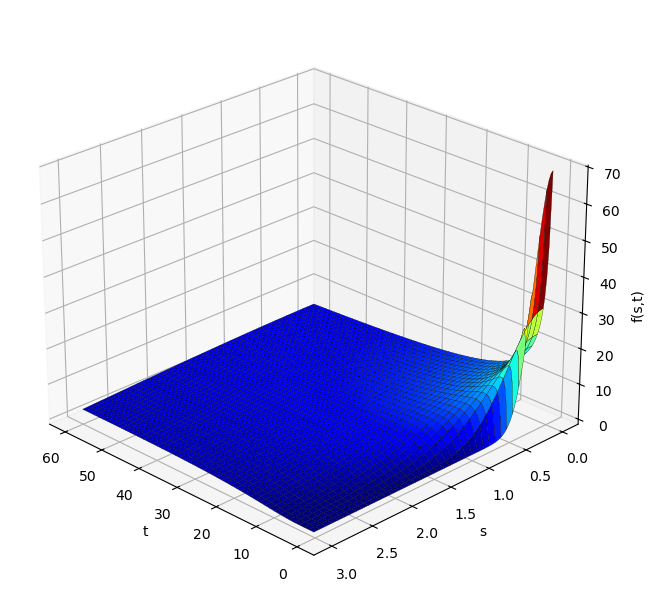

In [4]:
# Verify the correctness of function by plotting the output
# Parameters from the SFU page: M=10, D=0.07
x = np.array([10.0, 0.07])

# Create a denser spatial grid (0..3) to visualize a smooth surface; time grid as in page
s_grid = np.linspace(0.0, 3.0, 121)          
t_grid = np.arange(0.3, 60.0 + 1e-12, 0.3)  

Y = environ(x, s=s_grid, t=t_grid, return_grid=True)  # (ds, dt)

# Mesh for plotting
T, S = np.meshgrid(t_grid, s_grid, indexing='xy')

# Plot
fig = plt.figure(figsize=(8,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, S, Y, cmap='jet', edgecolor='k', linewidth=0.2, antialiased=True, shade=True)

ax.set_xlabel("t")
ax.set_ylabel("s")
ax.set_zlabel("")  # suppress default
ax.tick_params(axis='z', pad=2)
ax.text2D(1.05, 0.5, "f(s,t)", 
          transform=ax.transAxes,
          rotation=90, 
          va="center", ha="left",
          clip_on=False)
ax.view_init(elev=25, azim=135)
plt.savefig(IMG_DIR / "environ_surface_jet.png", dpi=300)
plt.show()

### Define Structural similarity index measure (SSIM) 

In [5]:
def per_run_ssim(gt, pred):
    scores = []
    scores = [ssim_fn(gt[i], pred[i], data_range=float(gt[i].max()-gt[i].min()))
          for i in range(len(gt))]
    return scores

def mean_behavior_ssim(gt_mean, pred_mean):
    ssim_score, ssim_map = ssim_fn(gt_mean, pred_mean, data_range=float(gt_mean.max()-gt_mean.min()), full=True)
    return ssim_score, ssim_map

### Define input domain

In [6]:
M_MIN_MAX = [7, 13]
D_MIN_MAX = [0.02, 0.12]
INPUT_DOMAIN = np.array([M_MIN_MAX, D_MIN_MAX])
POLLUTANT_CONCENTRATION_THRESHOLD = 5e-06

### Latin Hypercube Sampling to obtain input design points and output response

In [7]:
# Define LHS sampler
sampler = LHS(ndim=2, bounds=INPUT_DOMAIN)

# Generate samples to obtain input X
nsamples = 250
X = sampler.sample(nsamples)
print(f"Input X shape: {X.shape}")

# Evaluate function to obtain output Y
s_grid = np.linspace(0.0, 3.0, 50) 
t_grid = np.linspace(0.3, 20, 200)  
Y = environ(X, s=s_grid, t=t_grid, return_grid=True)
print(f"Output Y shape: {Y.shape}")     

Input X shape: (250, 2)
Output Y shape: (250, 50, 200)


### Train/Test Split

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
train_Y, valid_cols, rows, cols = zero_truncated_data(train_Y, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)
test_Y, _, rows, cols = zero_truncated_data(test_Y, threshold=POLLUTANT_CONCENTRATION_THRESHOLD, valid_cols=valid_cols)
bg_img_path = None
output_img_params = {
                    "filtered_columns": valid_cols, 
                    "output_img_rows": rows, 
                    "output_img_cols": cols, 
                    "background_img_path": bg_img_path,
                    }
print(f"Train X shape: {train_X.shape}, Train Y shape: {train_Y.shape}")
print(f"Test X shape: {test_X.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (200, 2), Train Y shape: (200, 9884)
Test X shape: (50, 2), Test Y shape: (50, 9884)


### GP variants
#### (1) PPGaSP in RobustGaSP

In [9]:
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])
    
# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean = predictions[:, :, 0]
predictions_lower = predictions[:, :, 1]
predictions_upper = predictions[:, :, 2]
predictions_std = predictions[:, :, 3]

ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time
}

The upper bounds of the range parameters are 34.50051 0.5735083 
The initial values of range parameters are 0.6900101 0.01147017 
Start of the optimization  1  : 
The number of iterations is  23 
 The value of the  marginal posterior  function is  11326169 
 Optimized range parameters are 34.50051 0.1529856 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.11964 0.001988798 
Start of the optimization  2  : 
The number of iterations is  28 
 The value of the  marginal posterior  function is  11326154 
 Optimized range parameters are 34.50051 0.1529774 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 


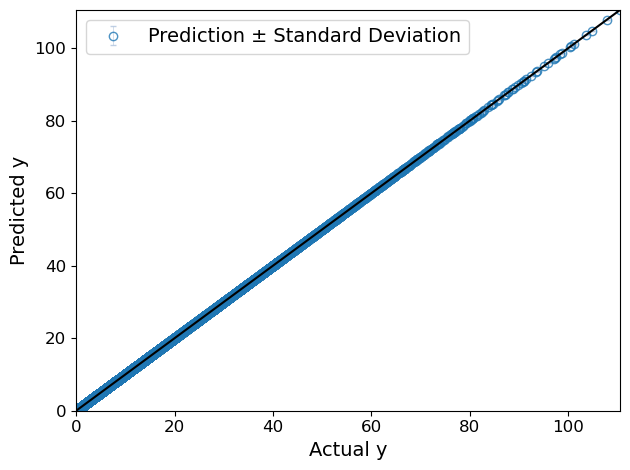

In [10]:
preds = np.dstack((predictions_mean, predictions_std))
viz_prediction(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

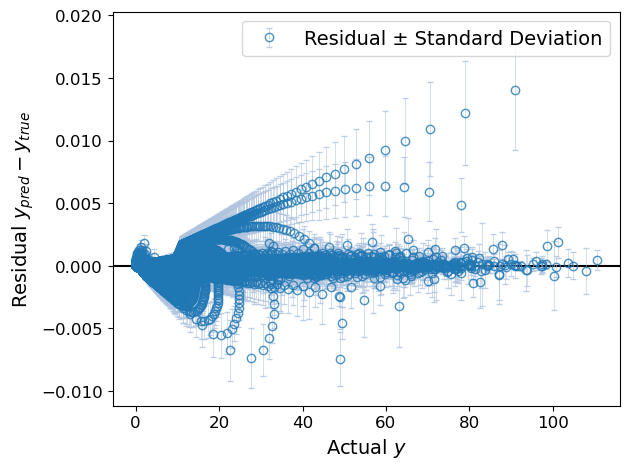

In [11]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

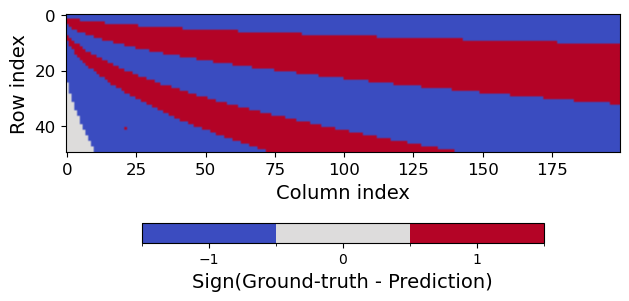

In [12]:
viz_diff_grid_points(test_Y, predictions_mean, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

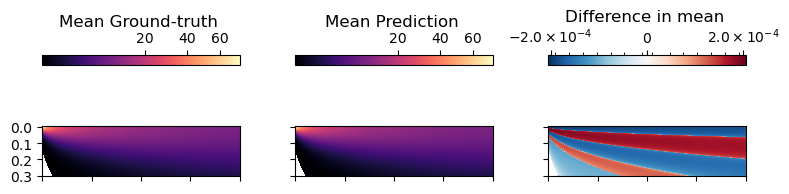

In [13]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

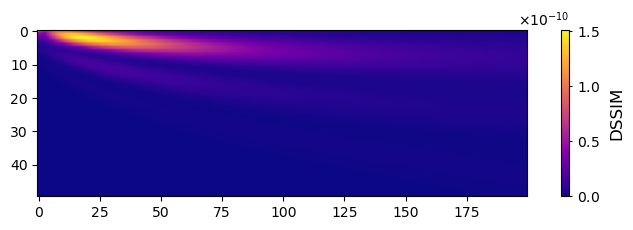

In [14]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [15]:
ground_truths_original = np.where(test_Y < POLLUTANT_CONCENTRATION_THRESHOLD, 0, test_Y)
predictions_mean = np.where(predictions_mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, predictions_mean)
predictions_lower = np.where(predictions_mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, predictions_lower)
predictions_upper = np.where(predictions_mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, predictions_upper)
predictions_std = np.where(predictions_mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, predictions_std)

# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)

# Store evaluation results in dictionary
ppgasp_results["rmse"] = rmse
ppgasp_results["coverage_prob"] = coverage_prob
ppgasp_results["quantile_coverage_error"] = quantile_coverage_error
ppgasp_results["dssim"] = (1 - np.mean(ssim_scores)) / 2
print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .5f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {ppgasp_results["dssim"]: .3}')

Training time: 19.762 s
Inference time: 0.026 s
RMSE:  0.00010
95% confidence interval coverage probability:  0.986
Quantile coverage error:  0.036
DSSIM:  3.5e-10


#### (2) BiGP (PPGaSP in GPytorch)

In [16]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = BiGP(device=device, kernel_type='matern_5_2')

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, num_epochs=50, lr=0.1, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

bigp_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "training_time": training_time,
    "infer_time": infer_time
}

training...:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50, Loss: 1.246


training...:  20%|██        | 10/50 [01:44<06:51, 10.29s/it]

Epoch 10/50, Loss: 0.839


training...:  40%|████      | 20/50 [03:35<05:41, 11.39s/it]

Epoch 20/50, Loss: 0.402


training...:  60%|██████    | 30/50 [05:46<04:24, 13.24s/it]

Epoch 30/50, Loss: -0.032


training...:  80%|████████  | 40/50 [08:40<03:11, 19.18s/it]

Epoch 40/50, Loss: -0.398


training...: 100%|██████████| 50/50 [14:17<00:00, 17.14s/it]


Training GPytorch takes 857.090 s


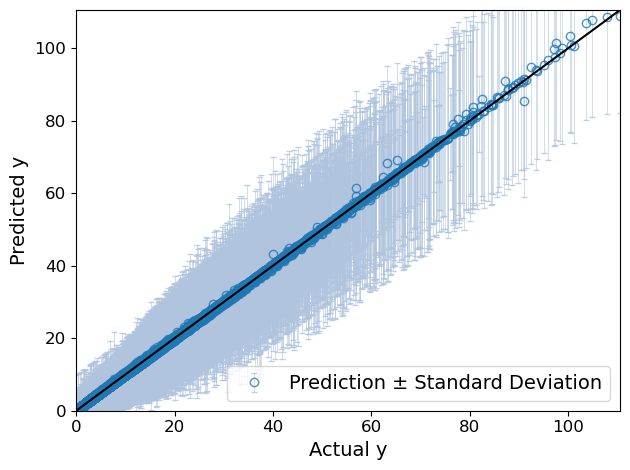

In [17]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

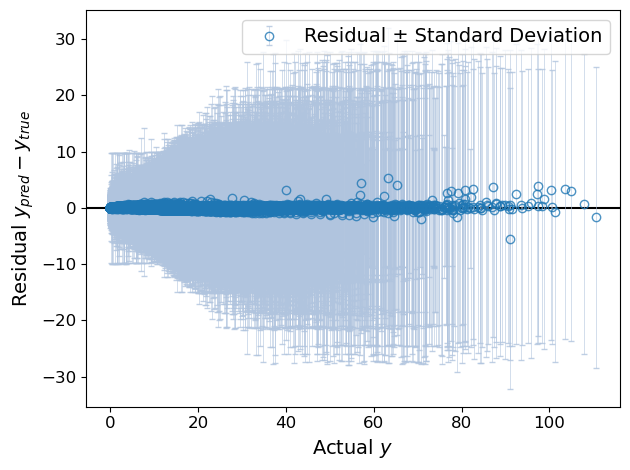

In [18]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

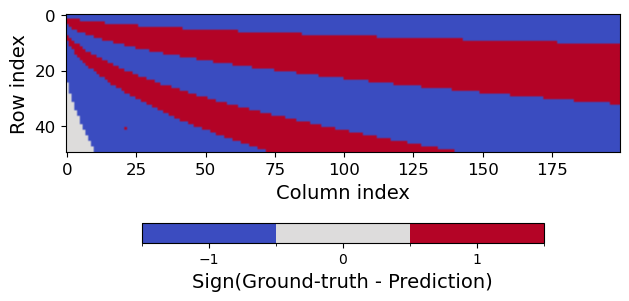

In [19]:
viz_diff_grid_points(test_Y, predictions_mean, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

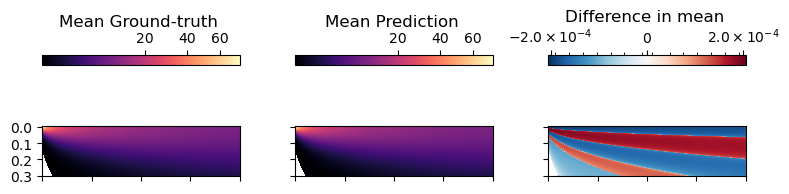

In [20]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

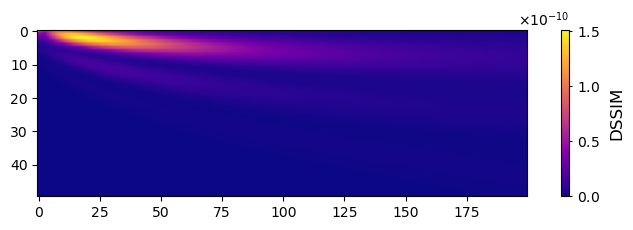

In [21]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [22]:
ground_truths_original = np.where(test_Y < POLLUTANT_CONCENTRATION_THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, mean)
predictions_lower = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, lower)
predictions_upper = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, upper)
predictions_std = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, std)

# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)    
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, predictions_lower, predictions_upper, ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, predictions_upper, ground_truths_original)
bigp_results["rmse"] = rmse
bigp_results["coverage_prob"] = coverage_prob
bigp_results["quantile_coverage_error"] = quantile_coverage_error
bigp_results["dssim"] = (1 - np.mean(ssim_scores)) / 2
print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .5f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {bigp_results["dssim"]: .3}')

Training time: 857.090 s
Inference time: 25.138 s
RMSE:  0.03126
95% confidence interval coverage probability:  0.990
Quantile coverage error:  0.040
DSSIM:  3.5e-10


#### (3) MTGP (LMC)

In [23]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MultiTaskGP(base_inducing=64, min_rank=10, use_pca_init=True, device=device)

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, epochs=500, lr=0.1, enable_scheduler=True)

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

lmc_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "training_time": training_time,
    "infer_time": infer_time
}

INFO:gpytorch_emulator.svgp_lmc:Normalizing data...
INFO:gpytorch_emulator.svgp_lmc:Problem size: 2 inputs → 9884 outputs
INFO:gpytorch_emulator.svgp_lmc:Training samples: 200
INFO:gpytorch_emulator.svgp_lmc:Base parameters: base_inducing=64, min_rank=10
INFO:gpytorch_emulator.svgp_lmc:Calculated parameters: rank=10, num_inducing=80
INFO:gpytorch_emulator.svgp_lmc:Explained variance at rank 10: 1.000
INFO:gpytorch_emulator.svgp_lmc:Initializing inducing points with k-means clustering...
INFO:gpytorch_emulator.svgp_lmc:Initialized inducing points with shape: torch.Size([10, 80, 2])
INFO:gpytorch_emulator.svgp_lmc:Initializing LMC mixing matrix with PCA...
INFO:gpytorch_emulator.svgp_lmc:PCA explained variance ratio: [6.1109787e-01 3.1908646e-01 6.0033869e-02 8.6643398e-03 1.0006141e-03
 1.0632148e-04 1.0267910e-05 9.4122413e-07 8.2741472e-08 5.9211724e-09]...
INFO:gpytorch_emulator.svgp_lmc:Total explained variance: 1.0000
INFO:gpytorch_emulator.svgp_lmc:LMC coefficients initialized wit

Epoch   0, Loss: 77039.047, Beta: 0.0010, LR: 0.005000


training...:   5%|▌         | 27/500 [00:01<00:30, 15.44it/s]

Epoch  25, Loss: 3009.941, Beta: 0.0010, LR: 0.099961


training...:  11%|█         | 53/500 [00:03<00:31, 14.28it/s]

Epoch  50, Loss: -3205.165, Beta: 0.0077, LR: 0.098974


training...:  16%|█▌        | 79/500 [00:05<00:29, 14.51it/s]

Epoch  75, Loss: -12366.421, Beta: 0.0240, LR: 0.096679


training...:  21%|██        | 103/500 [00:07<00:27, 14.59it/s]

Epoch 100, Loss: -13209.945, Beta: 0.0768, LR: 0.093137
  Avg lengthscale: 3.173, Avg outputscale: 0.250


training...:  25%|██▌       | 127/500 [00:08<00:27, 13.77it/s]

Epoch 125, Loss: -16834.242, Beta: 0.2235, LR: 0.088442


training...:  31%|███       | 153/500 [00:10<00:24, 13.89it/s]

Epoch 150, Loss: -18496.432, Beta: 0.5005, LR: 0.082721


training...:  36%|███▌      | 179/500 [00:12<00:22, 14.59it/s]

Epoch 175, Loss: -19699.846, Beta: 0.7775, LR: 0.076125


training...:  41%|████      | 203/500 [00:14<00:21, 13.76it/s]

Epoch 200, Loss: -20652.877, Beta: 0.9242, LR: 0.068831
  Avg lengthscale: 3.153, Avg outputscale: 0.259


training...:  45%|████▌     | 227/500 [00:16<00:19, 14.03it/s]

Epoch 225, Loss: -21450.096, Beta: 0.9770, LR: 0.061035


training...:  51%|█████     | 253/500 [00:18<00:18, 13.38it/s]

Epoch 250, Loss: -20269.709, Beta: 1.0000, LR: 0.052944


training...:  55%|█████▌    | 277/500 [00:20<00:15, 13.95it/s]

Epoch 275, Loss: -8171.333, Beta: 1.0000, LR: 0.044774


training...:  61%|██████    | 303/500 [00:21<00:13, 14.50it/s]

Epoch 300, Loss: -21085.094, Beta: 1.0000, LR: 0.036743
  Avg lengthscale: 3.156, Avg outputscale: 0.259


training...:  66%|██████▌   | 329/500 [00:23<00:11, 15.48it/s]

Epoch 325, Loss: -19777.014, Beta: 1.0000, LR: 0.029067


training...:  71%|███████   | 353/500 [00:25<00:09, 15.73it/s]

Epoch 350, Loss: -22537.418, Beta: 1.0000, LR: 0.021950


training...:  76%|███████▌  | 379/500 [00:26<00:07, 15.73it/s]

Epoch 375, Loss: -23107.770, Beta: 1.0000, LR: 0.015582


training...:  81%|████████  | 403/500 [00:28<00:06, 15.43it/s]

Epoch 400, Loss: -23523.422, Beta: 1.0000, LR: 0.010134
  Avg lengthscale: 3.141, Avg outputscale: 0.266


training...:  86%|████████▌ | 429/500 [00:30<00:04, 15.39it/s]

Epoch 425, Loss: -23745.451, Beta: 1.0000, LR: 0.005751


training...:  91%|█████████ | 453/500 [00:31<00:03, 15.63it/s]

Epoch 450, Loss: -23881.605, Beta: 1.0000, LR: 0.002549


training...:  96%|█████████▌| 479/500 [00:33<00:01, 15.35it/s]

Epoch 475, Loss: -23970.314, Beta: 1.0000, LR: 0.000616


training...: 100%|██████████| 500/500 [00:34<00:00, 14.41it/s]
INFO:gpytorch_emulator.svgp_lmc:Training time: 34.710 seconds
INFO:gpytorch_emulator.svgp_lmc:Starting evaluation with uncertainty quantification...
INFO:gpytorch_emulator.svgp_lmc:Inference time: 0.004 seconds


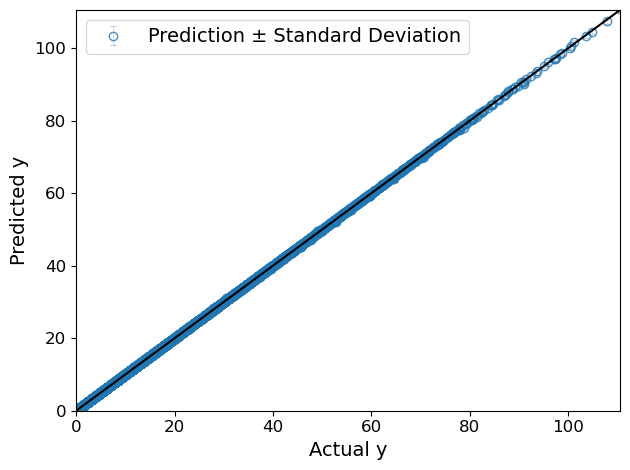

In [24]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

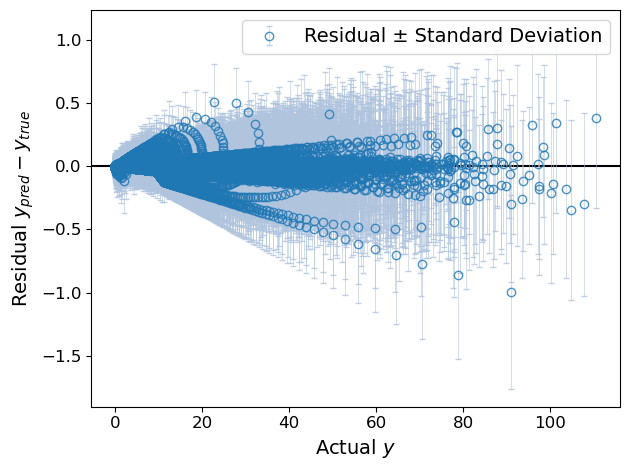

In [25]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

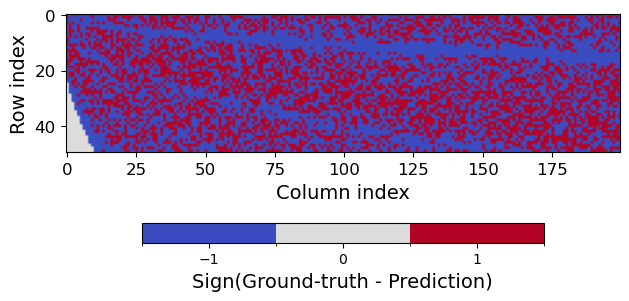

In [26]:
viz_diff_grid_points(test_Y, predictions_mean, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

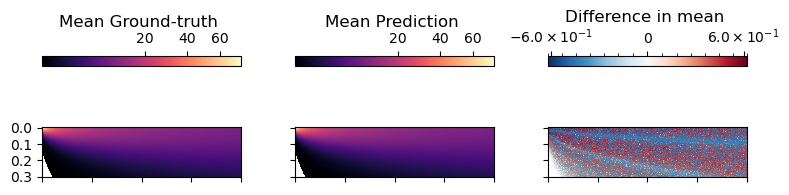

In [27]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

In [28]:
ground_truths_original = np.where(test_Y < POLLUTANT_CONCENTRATION_THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, mean)
predictions_lower = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, lower)
predictions_upper = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, upper)
predictions_std = np.where(mean < POLLUTANT_CONCENTRATION_THRESHOLD, 0, std)

# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                          predictions_lower, 
                                                          predictions_upper,
                                                          ground_truths_original)

quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                            predictions_upper,
                                                            ground_truths_original)
lmc_results["rmse"] = rmse
lmc_results["coverage_prob"] = coverage_prob
lmc_results["quantile_coverage_error"] = quantile_coverage_error

print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .5f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .5f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')

Training time: 34.710 s
Inference time: 0.004 s
RMSE:  0.00941
95% confidence interval coverage probability:  0.98860
Quantile coverage error:  0.039


### Comparative Study: Different dimensionality reduction approaches

#### PCA-PPGaSP

In [29]:
# Model setup
input_reducer  = None
output_reducer = OutputDimReducer(LinearPCA(n_components=10))
emulator = PCAPPGaSP(
        ndim=int(reduced_dim(input_reducer, train_X)),
        input_dim_reducer=input_reducer,
        output_dim_reducer=output_reducer,
    )
# Training
training_time = emulator.train(train_X, train_Y)

# Prediction
test_Y_scaled = emulator.output_scaler.transform(test_Y)
test_Y_scaled_reduced = emulator.output_dim_reducer.transform(test_Y_scaled)
predictions_latent, predictions_mean_original, infer_time, predictions_uncertainty = emulator.predict(test_X, uncertainty_reconstruction=True)

Explained variance when number of components is 10: 0.9999999994531102.
The upper bounds of the range parameters are 19.83088 19.53418 
The initial values of range parameters are 0.3966175 0.3906836 
Start of the optimization  1  : 
The number of iterations is  24 
 The value of the  marginal posterior  function is  4411.317 
 Optimized range parameters are 19.83088 3.863986 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.06876903 0.06774015 
Start of the optimization  2  : 
The number of iterations is  15 
 The value of the  marginal posterior  function is  4411.318 
 Optimized range parameters are 19.83088 3.863945 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
Training PCAPPGaSP takes 0.765 s
Inference PCAPPGaSP takes 0.003 s


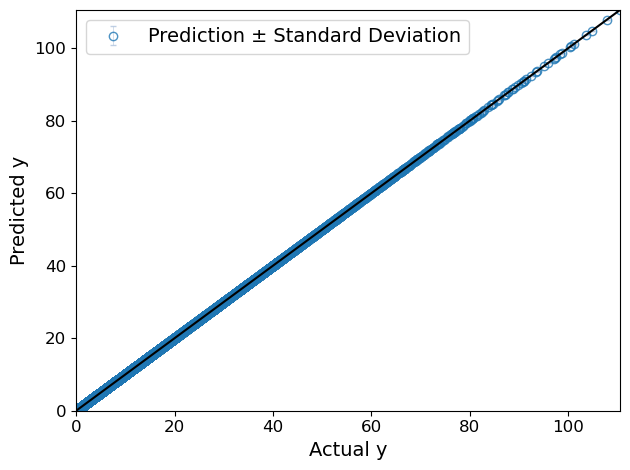

In [30]:
preds = np.dstack((predictions_mean_original, predictions_uncertainty[:, :, 2]))
viz_prediction(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

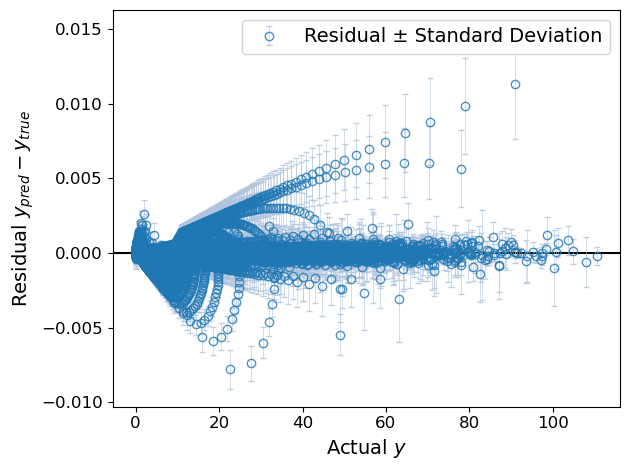

In [31]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

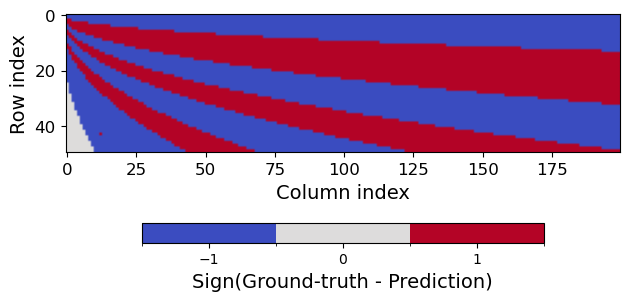

In [32]:
viz_diff_grid_points(test_Y, predictions_mean_original, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

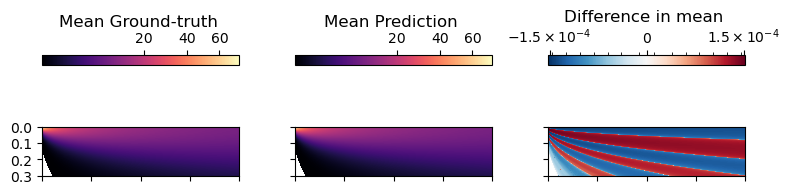

In [33]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean_original, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

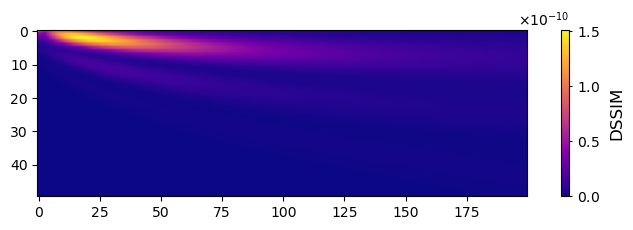

In [34]:
fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [35]:
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                        predictions_uncertainty[:, :, 0], 
                                                        predictions_uncertainty[:, :, 1],
                                                        test_Y)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_uncertainty[:, :, 0], 
                                                            predictions_uncertainty[:, :, 1],
                                                            test_Y)
        
# Evaluation metrics
pca_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": predictions_uncertainty[:, :, 2],
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "dssim": (1 - np.mean(ssim_scores)) / 2,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .3}')
print(f'95% confidence interval coverage probability: {coverage_prob: .4f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {pca_ppgasp_results["dssim"]: .3}')

Training time: 0.765 s
Inference time: 0.003 s
RMSE:  9.73e-05
95% confidence interval coverage probability:  0.9753
Quantile coverage error:  0.025
DSSIM:  3.5e-10


#### kPCA-PPGaSP

In [36]:
# Model setup
input_reducer  = None
output_reducer = OutputDimReducer(NonlinearPCA(n_components=10, alpha=1e-10))
emulator = PCAPPGaSP(
        ndim=int(reduced_dim(input_reducer, train_X)),
        input_dim_reducer=input_reducer,
        output_dim_reducer=output_reducer,
    )
# Training
training_time = emulator.train(train_X, train_Y)

# Prediction
predictions_latent, predictions_mean_original, infer_time, predictions_uncertainty = emulator.predict(test_X, uncertainty_reconstruction=True)

The upper bounds of the range parameters are 19.83088 19.53418 
The initial values of range parameters are 0.3966175 0.3906836 
Start of the optimization  1  : 
The number of iterations is  15 
 The value of the  marginal posterior  function is  7266.169 
 Optimized range parameters are 3.085294 1.428173 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 0.06876903 0.06774015 
Start of the optimization  2  : 
The number of iterations is  30 
 The value of the  marginal posterior  function is  7266.169 
 Optimized range parameters are 3.085294 1.428173 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
Training PCAPPGaSP takes 0.460 s
Inference PCAPPGaSP takes 0.001 s


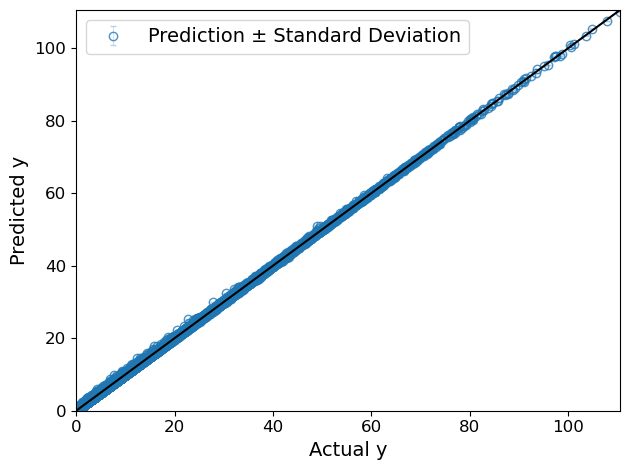

In [37]:
preds = np.dstack((predictions_mean_original , predictions_uncertainty[:, :, 2]))
viz_prediction(test_Y, preds)

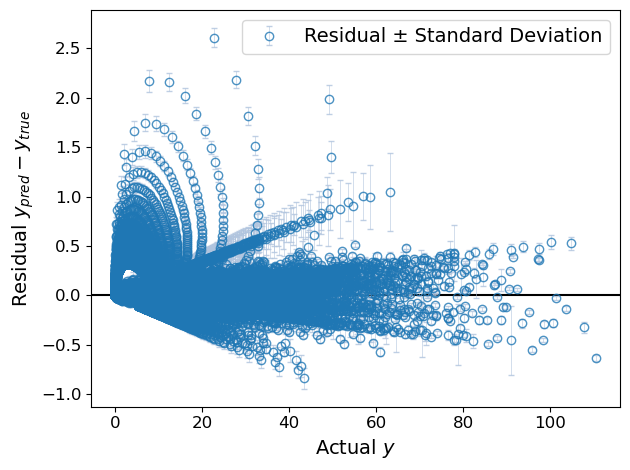

In [38]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

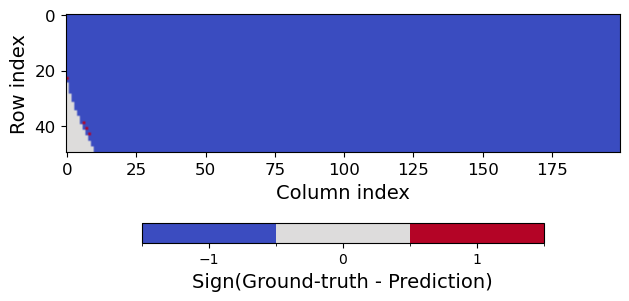

In [39]:
viz_diff_grid_points(test_Y, predictions_mean_original, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

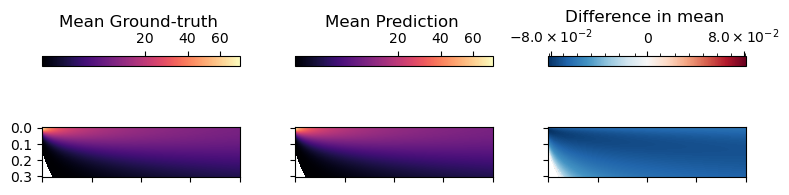

In [40]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean_original, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

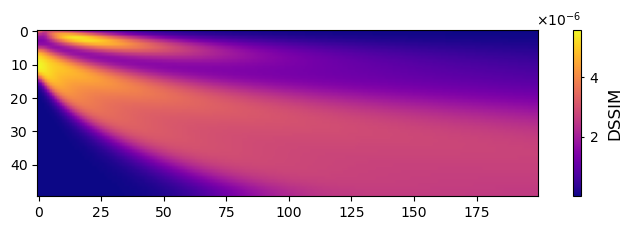

In [41]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [42]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 predictions_uncertainty[:, :, 0], 
                                                 predictions_uncertainty[:, :, 1],
                                                 test_Y)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_uncertainty[:, :, 0], 
                                                            predictions_uncertainty[:, :, 1],
                                                            test_Y)
kpca_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": predictions_uncertainty[:, :, 2],
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {kpca_ppgasp_results["dssim"]: .3}')

Training time: 0.460 s
Inference time: 0.001 s
RMSE:  0.048
95% confidence interval coverage probability:  0.155
Quantile coverage error:  0.795
DSSIM:  0.000161


#### AE-PPGaSP

In [43]:
train_Y_tensor = torch.FloatTensor(train_Y)
test_Y_tensor = torch.FloatTensor(test_Y)
y_mean = train_Y_tensor.mean(0, keepdim=True)
y_std = train_Y_tensor.std(0, keepdim=True)
train_Y_normalized = (train_Y_tensor - y_mean) / (y_std + 1e-8).to(device)  
# test_Y_normalized = (test_Y_tensor - y_mean) / (y_std + 1e-8).to(device)
input_dim = train_Y_tensor.shape[1]  # Number of input features
latent_dim = 10  # Desired number of output dimensions
model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=[1024, 256, 64, 64, 16])

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Training the autoencoder
losses = []
num_epochs = 500
model.train()
start_time = time.time()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_Y_normalized)
    loss = loss_function(outputs, train_Y_normalized)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Loss for each epoch
    losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
model.eval()
with torch.no_grad():
    train_Y_reduced = model.encoder(train_Y_normalized).detach().numpy()
dr_processing_time = time.time() - start_time

Epoch [1/500], Loss: 0.9957
Epoch [2/500], Loss: 0.9952
Epoch [3/500], Loss: 0.9951
Epoch [4/500], Loss: 0.9941
Epoch [5/500], Loss: 0.9913
Epoch [6/500], Loss: 0.9830
Epoch [7/500], Loss: 0.9637
Epoch [8/500], Loss: 0.9216
Epoch [9/500], Loss: 0.8407
Epoch [10/500], Loss: 0.7395
Epoch [11/500], Loss: 0.8517
Epoch [12/500], Loss: 0.6813
Epoch [13/500], Loss: 0.6260
Epoch [14/500], Loss: 0.6020
Epoch [15/500], Loss: 0.5426
Epoch [16/500], Loss: 0.4755
Epoch [17/500], Loss: 0.5774
Epoch [18/500], Loss: 0.4619
Epoch [19/500], Loss: 0.4119
Epoch [20/500], Loss: 0.4405
Epoch [21/500], Loss: 0.4615
Epoch [22/500], Loss: 0.4501
Epoch [23/500], Loss: 0.4341
Epoch [24/500], Loss: 0.4213
Epoch [25/500], Loss: 0.4062
Epoch [26/500], Loss: 0.3903
Epoch [27/500], Loss: 0.3866
Epoch [28/500], Loss: 0.3938
Epoch [29/500], Loss: 0.3896
Epoch [30/500], Loss: 0.3799
Epoch [31/500], Loss: 0.3860
Epoch [32/500], Loss: 0.3738
Epoch [33/500], Loss: 0.3650
Epoch [34/500], Loss: 0.3634
Epoch [35/500], Loss: 0

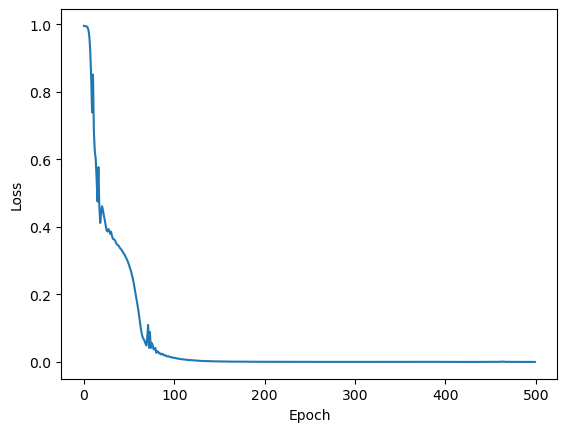

In [44]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [45]:
# GP setup
emulator = PPGaSP(ndim=train_X.shape[1])

# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y_reduced)
gp_training_time = time.time() - start_time
training_time = dr_processing_time + gp_training_time
# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

The upper bounds of the range parameters are 34.50051 0.5735083 
The initial values of range parameters are 0.6900101 0.01147017 
Start of the optimization  1  : 
The number of iterations is  26 
 The value of the  marginal posterior  function is  -3123.266 
 Optimized range parameters are 2.351455 0.02022288 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.11964 0.001988798 
Start of the optimization  2  : 
The number of iterations is  12 
 The value of the  marginal posterior  function is  -3123.266 
 Optimized range parameters are 2.351455 0.02022288 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


In [46]:
num_mc_samples = 100
original_dim = train_Y.shape[1]
mean_reduced = predictions[:, :, 0]
std_reduced = predictions[:, :, 3]
num_test, latent_dim = mean_reduced.shape
# Decode predictions
predictions_mean_normalized = model.decoder(torch.FloatTensor(predictions[:, :, 0])).detach().numpy()
predictions_mean_original = predictions_mean_normalized * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()
# Generate samples in reduced space
rng = np.random.default_rng()
latent_samples = rng.normal(loc=mean_reduced[:, :, None], scale=std_reduced[:, :, None], size=(num_test, latent_dim, num_mc_samples))
# Reconstruct original output space
original_samples = np.zeros((num_test, original_dim, num_mc_samples))
latent_flat = latent_samples.transpose(0, 2, 1).reshape(num_test * num_mc_samples, latent_dim)
original_flat = model.decoder(torch.FloatTensor(latent_flat)).detach().numpy()
original_flat = original_flat * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()
original_samples = original_flat.reshape(num_test, num_mc_samples, original_dim).transpose(0, 2, 1)
# Compute statistics across samples
std_original = np.std(original_samples, axis=2)
margin = 1.96 * std_original
lower_CI = predictions_mean_original - margin
upper_CI = predictions_mean_original + margin 

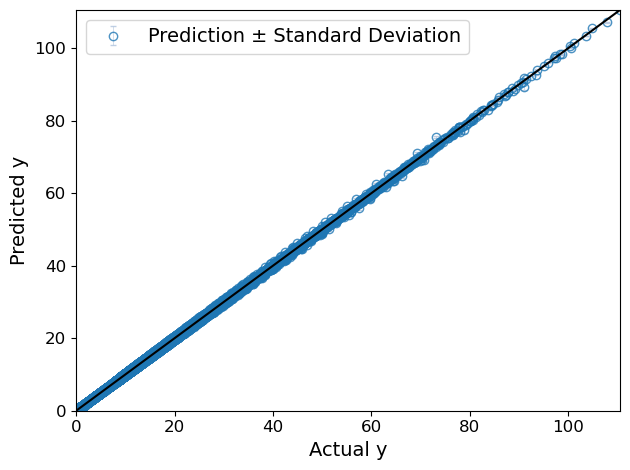

In [47]:
preds = np.dstack((predictions_mean_original, std_original))
viz_prediction(test_Y, preds)

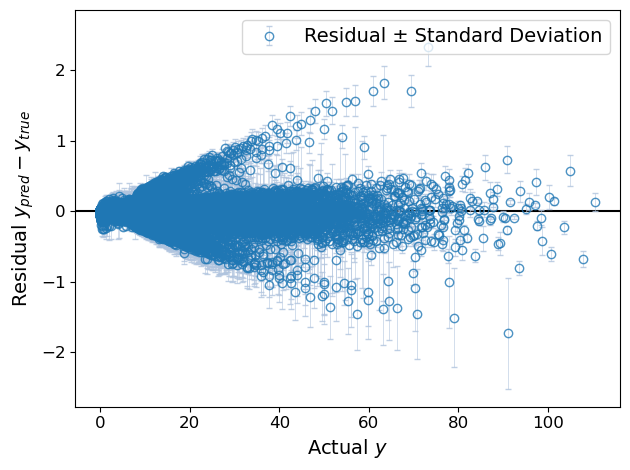

In [48]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)


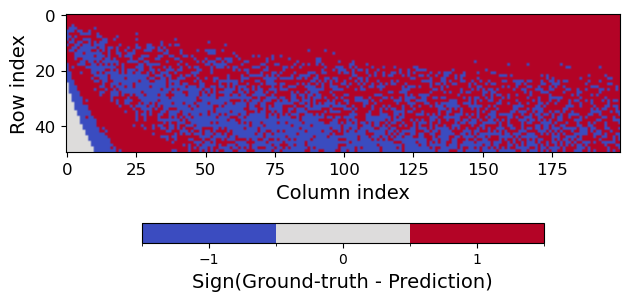

In [49]:
viz_diff_grid_points(test_Y, predictions_mean_original, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)


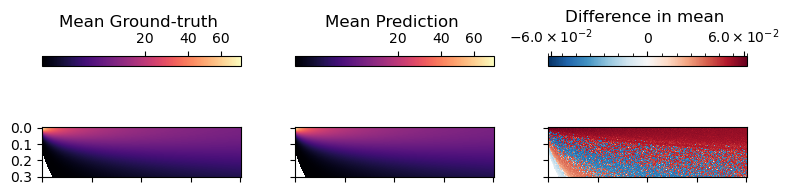

In [50]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean_original, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

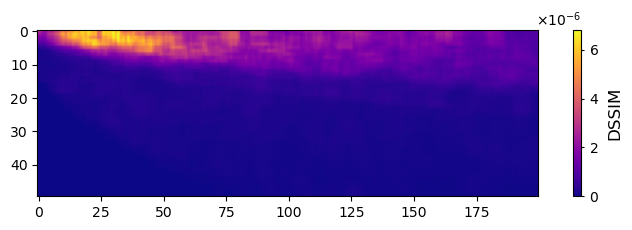

In [51]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [52]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 lower_CI, 
                                                 upper_CI,
                                                 test_Y)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(lower_CI, 
                                                            upper_CI,
                                                            test_Y)
ae_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": std_original,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {ae_ppgasp_results["dssim"]: .3}')

Training time: 33.966 s
Inference time: 0.002 s
RMSE:  0.033
95% confidence interval coverage probability:  0.538
Quantile coverage error:  0.412
DSSIM:  2.93e-05


#### VAE-PPGaSP

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_Y_tensor = torch.FloatTensor(train_Y)
test_Y_tensor = torch.FloatTensor(test_Y)

# Normalize your data
y_mean = train_Y_tensor.mean(0, keepdim=True)
y_std = train_Y_tensor.std(0, keepdim=True)
train_Y_normalized = (train_Y_tensor - y_mean) / (y_std + 1e-8)
test_Y_normalized = (test_Y_tensor - y_mean) / (y_std + 1e-8)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_Y_normalized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Setting random seed for reproducibility
input_dim = train_Y_tensor.shape[1]  # Number of input features
latent_dim = 10  # Desired number of output dimensions
model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=[2048, 1024, 256, 64] , device=device).to(device)

# Loss function and optimizer
def loss_function(x, x_hat, mean, log_var, epoch=None, total_epochs=None,
                  beta=1.0, capacity_max=25.0, capacity_warmup=0.3, free_bits=None):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='none')  # [B, D]
    recon_loss = recon_loss.sum(dim=1).mean()

    # KL per-dimension: shape [B, Z]
    kl_per_dim = -0.5 * (1 + log_var - mean.pow(2) - log_var.exp())

    # Optional free-bits: clamp per-dim contributions
    if free_bits is not None:
        kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)

    # Sum over latent dims, then mean over batch
    kl_loss = kl_per_dim.sum(dim=1).mean()

    # Capacity schedule
    if epoch is not None and total_epochs is not None:
        warmup_T = int(capacity_warmup * total_epochs)
        if epoch < warmup_T:
            C = capacity_max * (epoch / max(1, warmup_T))
        else:
            C = capacity_max
    else:
        C = capacity_max

    # β-VAE with capacity
    loss = recon_loss + beta * torch.abs(kl_loss - C)
    return loss, recon_loss, kl_loss, C
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-04, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-5
    )

# Training
losses = []
recon_losses = []
kl_losses = []
num_epochs = 1000
model.train()
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        outputs, mean, logvar = model(data)
        loss, recon_loss, kl_loss, C = loss_function(
            outputs, data, mean, logvar, 
            epoch=epoch, total_epochs=num_epochs,
            beta=0.1,              
            capacity_max=25.0,     
            capacity_warmup=0.3,   # 30% warmup
            free_bits=0.02         
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_kl = epoch_kl / len(train_loader)
    
    scheduler.step(avg_loss)
    
    losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.2f}, C: {C:.2f}")
        
        
# Encoding the data using the trained variational autoencoder
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    # Encode normalized data
    train_Y_reduced = model.encode(train_Y_normalized.to(device))[0].cpu().detach().numpy()
dr_processing_time = time.time() - start_time

Epoch [10/1000] Loss: 6716.7481, Recon: 6716.7045, KL: 1.19, C: 0.75
Epoch [20/1000] Loss: 4936.8092, Recon: 4936.6592, KL: 3.08, C: 1.58
Epoch [30/1000] Loss: 4012.8075, Recon: 4012.5538, KL: 4.95, C: 2.42
Epoch [40/1000] Loss: 2589.5602, Recon: 2589.1482, KL: 7.37, C: 3.25
Epoch [50/1000] Loss: 1917.6482, Recon: 1917.1566, KL: 9.00, C: 4.08
Epoch [60/1000] Loss: 1983.5000, Recon: 1982.9115, KL: 10.80, C: 4.92
Epoch [70/1000] Loss: 1452.8260, Recon: 1452.1659, KL: 12.35, C: 5.75
Epoch [80/1000] Loss: 1309.2873, Recon: 1308.5679, KL: 13.78, C: 6.58
Epoch [90/1000] Loss: 1274.2433, Recon: 1273.4523, KL: 15.33, C: 7.42
Epoch [100/1000] Loss: 1103.3341, Recon: 1102.5081, KL: 16.51, C: 8.25
Epoch [110/1000] Loss: 1021.8095, Recon: 1020.9352, KL: 17.83, C: 9.08
Epoch [120/1000] Loss: 1046.5360, Recon: 1045.6434, KL: 18.84, C: 9.92
Epoch [130/1000] Loss: 1247.8099, Recon: 1247.0014, KL: 18.84, C: 10.75
Epoch [140/1000] Loss: 949.9746, Recon: 949.1556, KL: 19.77, C: 11.58
Epoch [150/1000] Los

In [54]:
# GP setup
emulator = PPGaSP(ndim=train_X.shape[1])

# Train GP
start_time = time.time()
emulator.train(design=train_X, response=train_Y_reduced)
gp_training_time = time.time() - start_time
training_time = dr_processing_time + gp_training_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

# Decode predictions
predictions_mean_normalized = model.decode(torch.FloatTensor(predictions[:, :, 0]).to(device)).cpu().detach().numpy()
# Denormalize predictions
predictions_mean_original = predictions_mean_normalized * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()

The upper bounds of the range parameters are 34.50051 0.5735083 
The initial values of range parameters are 0.6900101 0.01147017 
Start of the optimization  1  : 
The number of iterations is  37 
 The value of the  marginal posterior  function is  -3470.702 
 Optimized range parameters are 1.020497 0.006588112 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.11964 0.001988798 
Start of the optimization  2  : 
The number of iterations is  14 
 The value of the  marginal posterior  function is  -3470.702 
 Optimized range parameters are 1.020497 0.006588111 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


In [55]:
num_mc_samples = 100
original_dim = train_Y.shape[1]
mean_reduced = predictions[:, :, 0]
std_reduced = predictions[:, :, 3]
num_test, latent_dim = mean_reduced.shape
# Generate samples in reduced space
rng = np.random.default_rng()
latent_samples = rng.normal(loc=mean_reduced[:, :, None], scale=std_reduced[:, :, None], size=(num_test, latent_dim, num_mc_samples))
# Reconstruct original output space
original_samples = np.zeros((num_test, original_dim, num_mc_samples))
latent_flat = latent_samples.transpose(0, 2, 1).reshape(num_test * num_mc_samples, latent_dim)
original_flat = model.decode(torch.FloatTensor(latent_flat).to(device)).cpu().detach().numpy()
original_flat = original_flat * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()
original_samples = original_flat.reshape(num_test, num_mc_samples, original_dim).transpose(0, 2, 1)
# Compute statistics across samples
std_original = np.std(original_samples, axis=2)
margin = 1.96 * std_original
lower_CI = predictions_mean_original - margin
upper_CI = predictions_mean_original + margin 

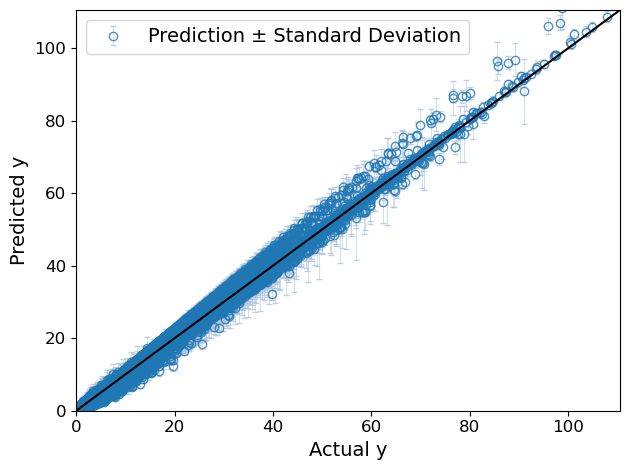

In [56]:
preds = np.dstack((predictions_mean_original, std_original))
viz_prediction(test_Y, preds)

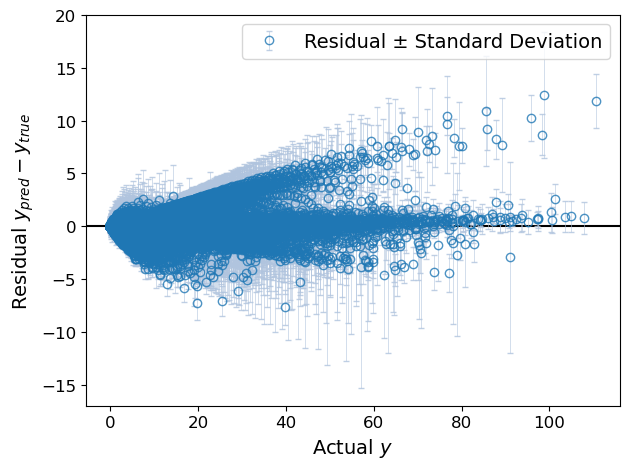

In [57]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

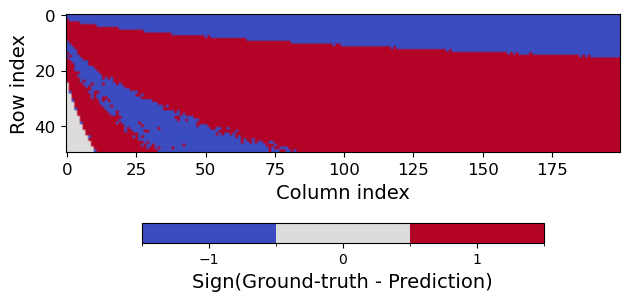

In [58]:
viz_diff_grid_points(test_Y, predictions_mean_original, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)


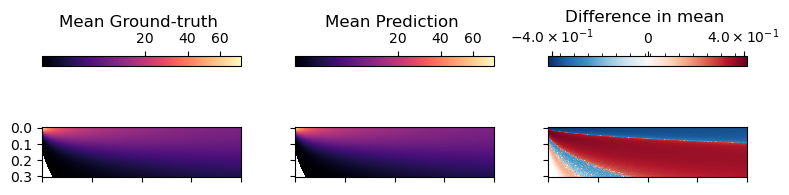

In [59]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, predictions_mean_original, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

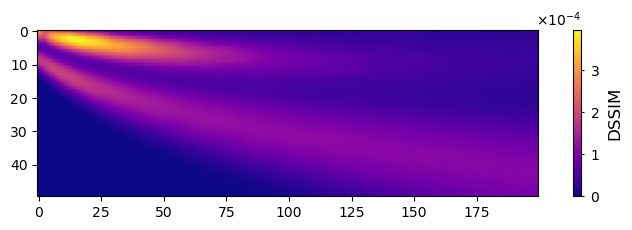

In [60]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [61]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 lower_CI, 
                                                 upper_CI,
                                                 test_Y)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(
    lower_CI,
    upper_CI,
    test_Y
)
vae_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": std_original,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {ae_ppgasp_results["dssim"]: .3}')

Training time: 950.706 s
Inference time: 0.006 s
RMSE:  0.276
95% confidence interval coverage probability:  0.826
Quantile coverage error:  0.124
DSSIM:  2.93e-05


#### Output distributions of different DR approaches with PPGaSP

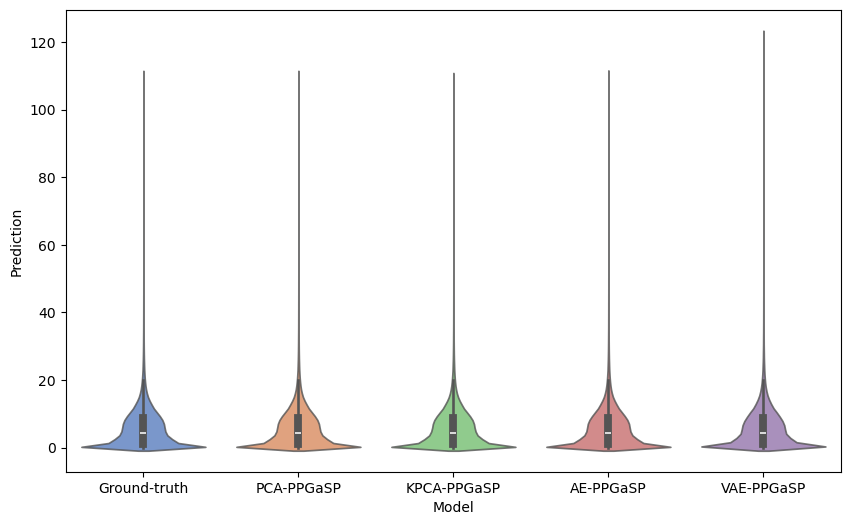

In [62]:
ground_truths_original = np.where(ground_truths_original < POLLUTANT_CONCENTRATION_THRESHOLD, 0, ground_truths_original)
pca_ppgasp_results["prediction_mean"] = np.where(pca_ppgasp_results["prediction_mean"] < POLLUTANT_CONCENTRATION_THRESHOLD, 0, pca_ppgasp_results["prediction_mean"])
kpca_ppgasp_results["prediction_mean"] = np.where(kpca_ppgasp_results["prediction_mean"] < POLLUTANT_CONCENTRATION_THRESHOLD, 0, kpca_ppgasp_results["prediction_mean"])
ae_ppgasp_results["prediction_mean"] = np.where(ae_ppgasp_results["prediction_mean"] < POLLUTANT_CONCENTRATION_THRESHOLD, 0, ae_ppgasp_results["prediction_mean"])
vae_ppgasp_results["prediction_mean"] = np.where(vae_ppgasp_results["prediction_mean"] < POLLUTANT_CONCENTRATION_THRESHOLD, 0, vae_ppgasp_results["prediction_mean"])

model_prediction_pairs = [
    ("Ground-truth", np.ravel(ground_truths_original)),
    ("PCA-PPGaSP",  np.ravel(pca_ppgasp_results["prediction_mean"])),
    ("KPCA-PPGaSP",  np.ravel(kpca_ppgasp_results["prediction_mean"])),
    ("AE-PPGaSP",    np.ravel(ae_ppgasp_results["prediction_mean"])),
    ("VAE-PPGaSP",   np.ravel(vae_ppgasp_results["prediction_mean"])),
]
model_predictions = [(name, value) for name, array in model_prediction_pairs for value in array]
df = pd.DataFrame(model_predictions, columns=["Model", "Prediction"])
colors = sns.color_palette("muted", n_colors=len(model_prediction_pairs))
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Model", y="Prediction", hue="Model", fill=True, alpha=.8, palette=colors)
plt.show()

### Comparative study: PCA + GP variants
#### PCA-BiGP

In [ ]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
output_reducer = OutputDimReducer(LinearPCA(n_components=10))
emulator = PCA_BiGP(output_reducer, device=device, kernel_type='matern_5_2')
    
# Preprocessing (dimenionality reduction)
train_X_scaled, train_Y_scaled_reduced, test_X_scaled, test_Y_scaled_reduced = emulator.preprocess_dim_reduction(train_X, train_Y, test_X, test_Y)
    
# Training
training_time = emulator.train(train_X_scaled, train_Y_scaled_reduced, num_epochs=100, lr=0.05, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X_scaled)    

# Postprocessing (Revert back to original space)
mean_original, std_original, lower_CI, upper_CI = emulator.postprocess_invert_back(mean, std)

Explained variance when number of components is 10: 0.9999999994531104.
Reduced output dimension to 10.


training...:   2%|▏         | 2/100 [00:00<00:05, 17.48it/s]

Epoch 0/100, Loss: 1.459


training...:  20%|██        | 20/100 [00:00<00:01, 48.19it/s]

Epoch 10/100, Loss: 1.344
Epoch 20/100, Loss: 1.247


training...:  36%|███▌      | 36/100 [00:00<00:01, 48.27it/s]

Epoch 30/100, Loss: 1.156
Epoch 40/100, Loss: 1.054


training...:  58%|█████▊    | 58/100 [00:01<00:00, 49.12it/s]

Epoch 50/100, Loss: 0.957


training...:  69%|██████▉   | 69/100 [00:01<00:00, 46.33it/s]

Epoch 60/100, Loss: 0.853
Epoch 70/100, Loss: 0.729


training...:  87%|████████▋ | 87/100 [00:01<00:00, 51.10it/s]

Epoch 80/100, Loss: 0.607
Epoch 90/100, Loss: 0.455


training...: 100%|██████████| 100/100 [00:02<00:00, 48.08it/s]

Training GPytorch takes 2.083 s
Inverse transform back to original output dimension: 9884.


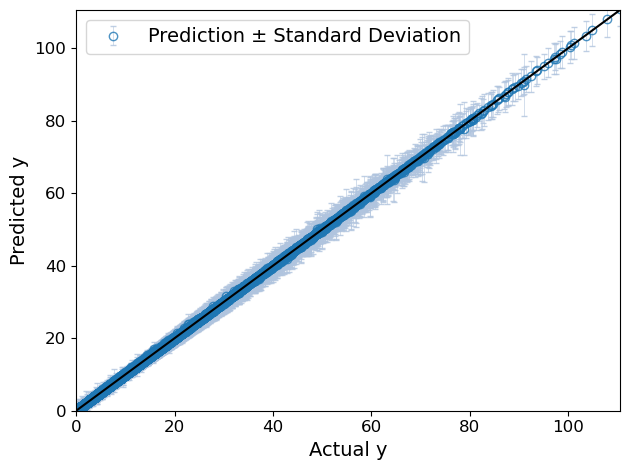

In [ ]:
preds = np.dstack((mean_original, std_original))
viz_prediction(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

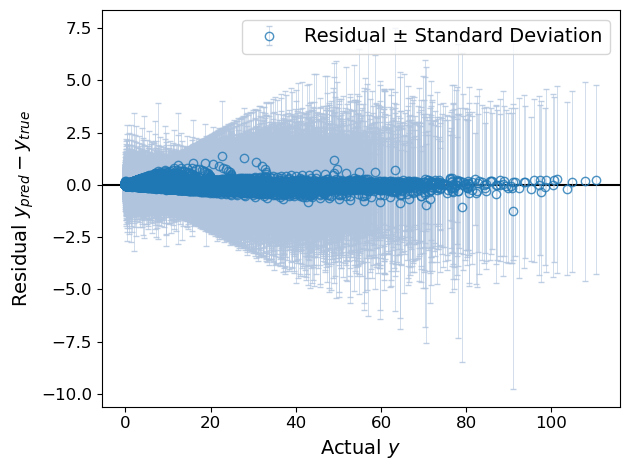

In [ ]:
viz_residuals(test_Y, preds, threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

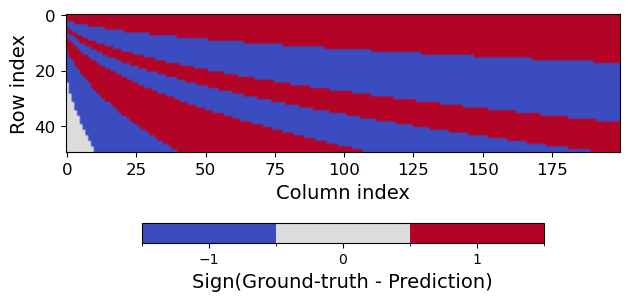

In [ ]:
viz_diff_grid_points(test_Y, mean_original, output_img_params, mode="binary", threshold=POLLUTANT_CONCENTRATION_THRESHOLD)

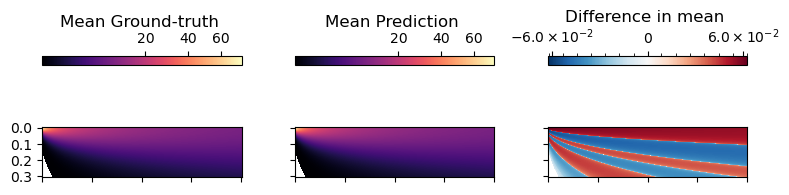

In [ ]:
x_ticks = [0.3, 5, 10, 15, 20]
y_ticks = [0.0, 0.1, 0.2, 0.3]
gts, preds, gt_mean, pred_mean, gt_std, pred_std = viz_output_image(test_Y, mean_original, output_img_params, qoi="cmax", threshold=POLLUTANT_CONCENTRATION_THRESHOLD, x_ticks=x_ticks, y_ticks=y_ticks, use_nonlinear_scale_colormap=True, prediction_cmap="magma", show_std_maps=False)

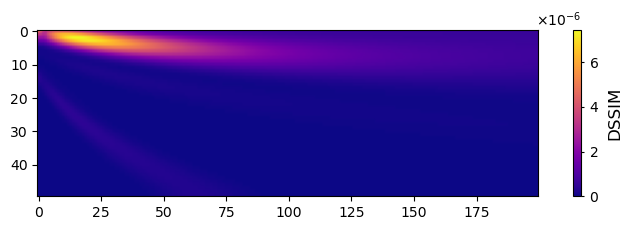

In [ ]:
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(6.5, 2.4))
im = ax.imshow(dssim_map, cmap='plasma', aspect="auto", rasterized=True)
ax.tick_params(width=0.8, length=3.5)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0.06, fraction=0.08)
cbar.set_label('DSSIM', labelpad=6, fontsize=12)
cbar.ax.tick_params(length=2.5, labelsize=10)
# Scientific notation
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-2, 2))
cbar.update_ticks()
fig.align_labels()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(mean_original, 
                                                 lower_CI, 
                                                 upper_CI,
                                                 test_Y)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(
    lower_CI,
    upper_CI,
    test_Y
)

pca_bigp_results = {
    "prediction_mean": mean_original,
    "prediction_lower": lower_CI,
    "prediction_upper": upper_CI,
    "prediction_std": std_original,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training time: {(training_time):.3f} s")
print(f"Inference time: {(infer_time):.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {pca_bigp_results["dssim"]: .3}')

Training time: 2.083 s
Inference time: 0.049 s
RMSE:  0.028
95% confidence interval coverage probability:  1.000
Quantile coverage error:  0.050
DSSIM:  2.73e-05


#### All models benchmarking results

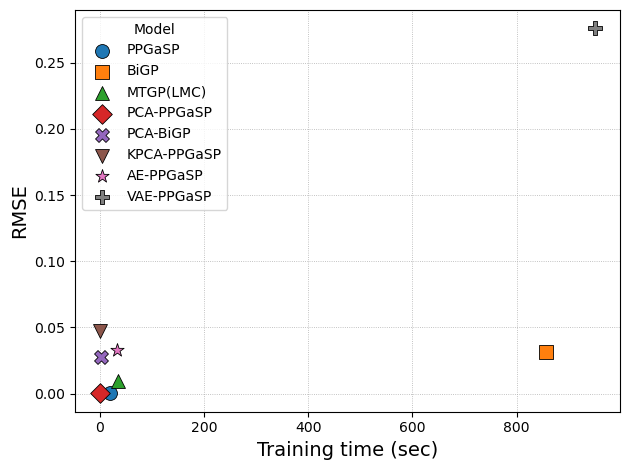

In [101]:
model_rmse_runtime_pairs = [
    ("PPGaSP", ppgasp_results["rmse"], ppgasp_results["training_time"]),
    ("BiGP", bigp_results["rmse"], bigp_results["training_time"]),
    ("MTGP(LMC)", lmc_results["rmse"], lmc_results["training_time"]),
    ("PCA-PPGaSP",  pca_ppgasp_results["rmse"], pca_ppgasp_results["training_time"]),
    ("PCA-BiGP", pca_bigp_results["rmse"], pca_bigp_results["training_time"]),
    ("KPCA-PPGaSP",  kpca_ppgasp_results["rmse"], kpca_ppgasp_results["training_time"]),
    ("AE-PPGaSP",    ae_ppgasp_results["rmse"], ae_ppgasp_results["training_time"]),
    ("VAE-PPGaSP",   vae_ppgasp_results["rmse"], vae_ppgasp_results["training_time"]),
]
plt.figure()
tab10 = plt.get_cmap("tab10").colors
markers = ["o", "s", "^", "D", "X", "v", "*", "P"]
for i, pair in enumerate(model_rmse_runtime_pairs):
    model_name, rmse, train_time = pair
    color = tab10[i % len(tab10)]
    marker = markers[i % len(markers)]
    plt.scatter(train_time, rmse, color=color, marker=marker, s=100, label=model_name, edgecolors="black", linewidths=0.6, zorder=3)
plt.xlabel("Training time (sec)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.grid(True, linestyle=":", linewidth=0.6, zorder=0)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

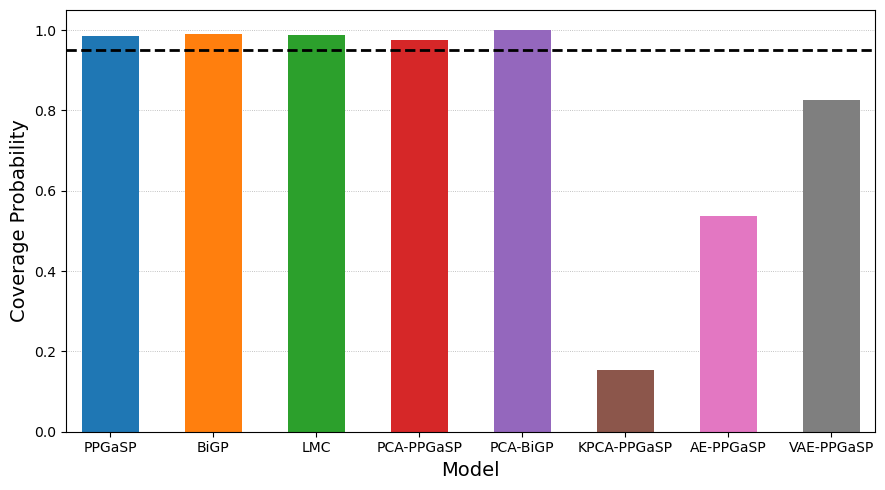

In [108]:
model_names = ["PPGaSP", "BiGP", "LMC", "PCA-PPGaSP", "PCA-BiGP", "KPCA-PPGaSP", "AE-PPGaSP", "VAE-PPGaSP"]
coverage_probs = [ppgasp_results["coverage_prob"], 
                  bigp_results["coverage_prob"], 
                  lmc_results["coverage_prob"], 
                  pca_ppgasp_results["coverage_prob"], 
                  pca_bigp_results["coverage_prob"], 
                  kpca_ppgasp_results["coverage_prob"], 
                  ae_ppgasp_results["coverage_prob"], 
                  vae_ppgasp_results["coverage_prob"]]
x = np.arange(len(model_names))
width = 0.55
tab10 = plt.get_cmap("tab10").colors
bar_colors = [tab10[i % len(tab10)] for i in range(len(model_names))]
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x, coverage_probs, width=width, color=bar_colors, zorder=2)
ax.axhline(0.95, color="black", linestyle="--", linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("Coverage Probability", fontsize=14)
ax.grid(axis="y", linestyle=":", linewidth=0.6, zorder=0)
ax.margins(x=0.02)
fig.tight_layout()
plt.show()